# SOLVING DEADLOCK IN MESHES

In [46]:
print("hello world")

hello world


In [47]:
!python3 -m pip install networkx matplotlib


# Creating the graph and position information

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import matplotlib.animation as animation

# Create a mesh network (4x4 example)
size_x = 5
size_y = 7
G = nx.grid_2d_graph(size_x, size_y)

positions = {(x, y): (x, -y) for x, y in G.nodes()}  # for plotting


# Routing Algorithms implementation

In [49]:
#  XY Routing Function 
def xy_routing(src, dst):
    path = []
    x1, y1 = src
    x2, y2 = dst

    x_step = 1 if x2 > x1 else -1
    for x in range(x1, x2, x_step):
        path.append((x, y1))

    y_step = 1 if y2 > y1 else -1
    for y in range(y1, y2, y_step):
        path.append((x2, y))

    path.append(dst)
    return path

In [50]:
# Valiant Routing Algorithm
def valiant_routing(G, source, destination):
    # Step 1: Choose an intermediate node randomly within the same layer (row or column)
    all_nodes = list(G.nodes())
    all_nodes.remove(source)
    intermediate_node = random.choice(all_nodes)
    
    # Step 2: Find the path from source to intermediate node
    # path_to_intermediate = nx.shortest_path(G, source, intermediate_node)
    path_to_intermediate = xy_routing(source, intermediate_node)
    
    # Step 3: Find the path from intermediate node to destination
    # path_from_intermediate = nx.shortest_path(G, intermediate_node, destination)
    path_from_intermediate = xy_routing(intermediate_node, destination)
    
    # Combine the paths (excluding the intermediate node from the second path)
    full_path = path_to_intermediate + path_from_intermediate[1:]
    
    return full_path, intermediate_node

# Helper functions for drawing and animation

In [51]:

#demonstrate one path
def draw_packet_path(G, positions, path, title="Packet Path", color="red"):
    """
    Visualizes a path through a 2D mesh network.
    
    Parameters:
    - G: The NetworkX graph (e.g., grid_2d_graph)
    - positions: Node positions for plotting
    - path: List of node tuples representing the path
    - title: Title for the plot
    - color: Edge color for the path
    """
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos=positions, with_labels=True, node_color="lightblue", node_size=600)
    
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos=positions, edgelist=path_edges, edge_color=color, width=7)
    
    plt.title(title)
    plt.show()


In [52]:
#demonstrate multiple paths
def draw_multiple_paths(G, positions, packet_paths, title="Simultaneous Packet Paths"):
    """
    Draws multiple packet paths on the same network graph.

    Parameters:
    - G: The networkx graph (e.g., 4x4 mesh)
    - positions: Dict of node positions for plotting
    - packet_paths: List of paths (each path is a list of node tuples)
    - title: Title for the plot
    """
    plt.figure(figsize=(7, 7))
    nx.draw(G, pos=positions, with_labels=True, node_color="lightblue", node_size=600)

    # Generate unique colors for each packet
    colors = cm.get_cmap('tab10', len(packet_paths))  # tab10 = 10 distinct colors

    for i, path in enumerate(packet_paths):
        edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(G, pos=positions, edgelist=edges, edge_color=[colors(i)], width=7, alpha=1)
        # label packets
        plt.text(path[0][0], -path[0][1] + 0.2, f'P{i+1}', fontsize=10, color=colors(i))

    plt.title(title)
    plt.show()



In [53]:


def animate_packet_paths(G, positions, packet_paths, title="Simultaneous Packet Paths Animation", interval=500):
    """
    Animates the movement of multiple packet paths on the same network graph.

    Parameters:
    - G: The NetworkX graph (e.g., grid_2d_graph)
    - positions: Dict of node positions for plotting
    - packet_paths: List of paths (each path is a list of node tuples)
    - title: Title for the plot
    - interval: Delay between each packet movement step (ms)
    """
    fig, ax = plt.subplots(figsize=(7, 7))

    # Generate unique colors for each packet
    colors = cm.get_cmap('tab10', len(packet_paths))  # tab10 = 10 distinct colors

    # Initial drawing of the graph
    nx.draw(G, pos=positions, with_labels=True, node_color="lightblue", node_size=600, ax=ax)
    
    # Prepare a list of line objects (for each packet)
    lines = []
    for i in range(len(packet_paths)):
        line, = ax.plot([], [], lw=7, color=colors(i))
        lines.append(line)
    
    # Function to initialize the animation (optional)
    def init():
        for line in lines:
            line.set_data([], [])
        return lines

    # Update function for each frame
    def update(frame):
        for i, path in enumerate(packet_paths):
            if frame < len(path) - 1:
                # Extract the start and end points of the current segment
                x_values = [path[frame][0], path[frame + 1][0]]
                y_values = [-path[frame][1], -path[frame + 1][1]]

                # Update the packet line with new coordinates
                lines[i].set_data(x_values, y_values)
        
        return lines

    # Set up the animation
    ani = animation.FuncAnimation(fig, update, frames=max(len(p) for p in packet_paths), 
                                  init_func=init, blit=True, interval=interval)
    ani.save("packets.mp4", writer='ffmpeg')

    plt.title(title)
    plt.show()




# Setting up traffic

In [54]:
#  Simulate Traffic for xy routing
num_packets = 10
packet_info = []  # [(src, dst, path, latency)]


for _ in range(num_packets):
    src = (random.randint(0, size_x - 1), random.randint(0, size_y - 1))
    dst = (random.randint(0, size_x - 1), random.randint(0, size_y - 1))
    while dst == src:
        dst = (random.randint(0, size_x - 1), random.randint(0, size_y - 1))
    
    path = xy_routing(src, dst)
    latency = len(path) - 1  # hop count
    packet_info.append((src, dst, path, latency))

#  Output Result 
for i, (src, dst, path, latency) in enumerate(packet_info):
    print(f"Packet {i}: {src} -> {dst} | Path: {path} | Latency: {latency}")

Packet 0: (3, 5) -> (3, 1) | Path: [(3, 5), (3, 4), (3, 3), (3, 2), (3, 1)] | Latency: 4
Packet 1: (0, 6) -> (3, 1) | Path: [(0, 6), (1, 6), (2, 6), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1)] | Latency: 8
Packet 2: (0, 4) -> (2, 5) | Path: [(0, 4), (1, 4), (2, 4), (2, 5)] | Latency: 3
Packet 3: (0, 1) -> (0, 5) | Path: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)] | Latency: 4
Packet 4: (3, 6) -> (2, 5) | Path: [(3, 6), (2, 6), (2, 5)] | Latency: 2
Packet 5: (4, 3) -> (0, 3) | Path: [(4, 3), (3, 3), (2, 3), (1, 3), (0, 3)] | Latency: 4
Packet 6: (0, 1) -> (1, 3) | Path: [(0, 1), (1, 1), (1, 2), (1, 3)] | Latency: 3
Packet 7: (3, 3) -> (1, 4) | Path: [(3, 3), (2, 3), (1, 3), (1, 4)] | Latency: 3
Packet 8: (3, 0) -> (4, 2) | Path: [(3, 0), (4, 0), (4, 1), (4, 2)] | Latency: 3
Packet 9: (4, 1) -> (3, 4) | Path: [(4, 1), (3, 1), (3, 2), (3, 3), (3, 4)] | Latency: 4


In [55]:
# tupples to simulate a simple deadlock situation
deadlock_paths = [
    ((1, 1), (2, 1), [(1, 1), (2, 1)], 1),  # P1
    ((2, 1), (2, 2), [(2, 1), (2, 2)], 1),  # P2
    ((2, 2), (1, 2), [(2, 2), (1, 2)], 1),  # P3
    ((1, 2), (1, 1), [(1, 2), (1, 1)], 1),  # P4
]

# SINGLE PATH

## XY

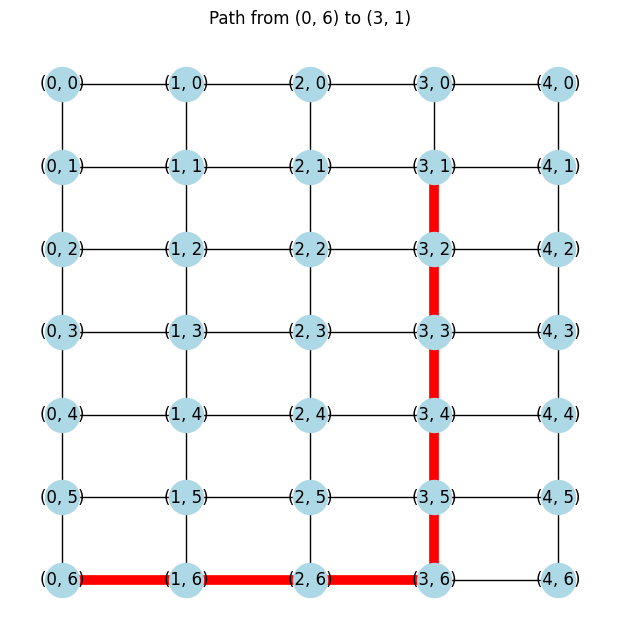

In [56]:
#lets see what X_Y routing looks like for a single packet
chosen_packet = 1
src, dst, path, _ = packet_info[chosen_packet]  # or any packet
draw_packet_path(G, positions, path, title=f"Path from {src} to {dst}")

## Valiant

Full Path: [(0, 6), (0, 5), (0, 4), (0, 3), (1, 3), (2, 3), (3, 3), (3, 2), (3, 1)] via Intermediate Node: (0, 3)


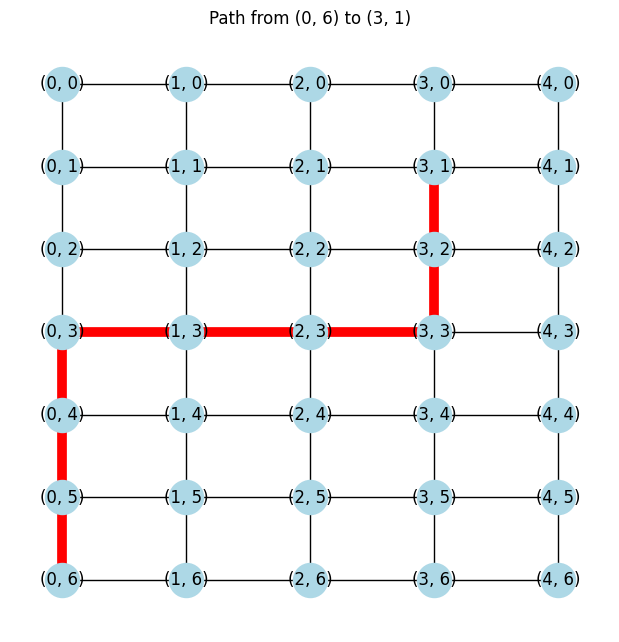

In [57]:
# draw for a single path for valiant routing
src, dst, path, _ = packet_info[chosen_packet]  # or any packet

# Perform Valiant Routing
full_path, intermediate_node = valiant_routing(G, src, dst)
print(f"Full Path: {full_path} via Intermediate Node: {intermediate_node}")

# # Visualize the network and the routing path
draw_packet_path(G, positions, full_path, title=f"Path from {src} to {dst}")

# Deadlock with multiple paths

## XY Routing

/tmp/ipykernel_67617/2495445561.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(packet_paths))  # tab10 = 10 distinct colors


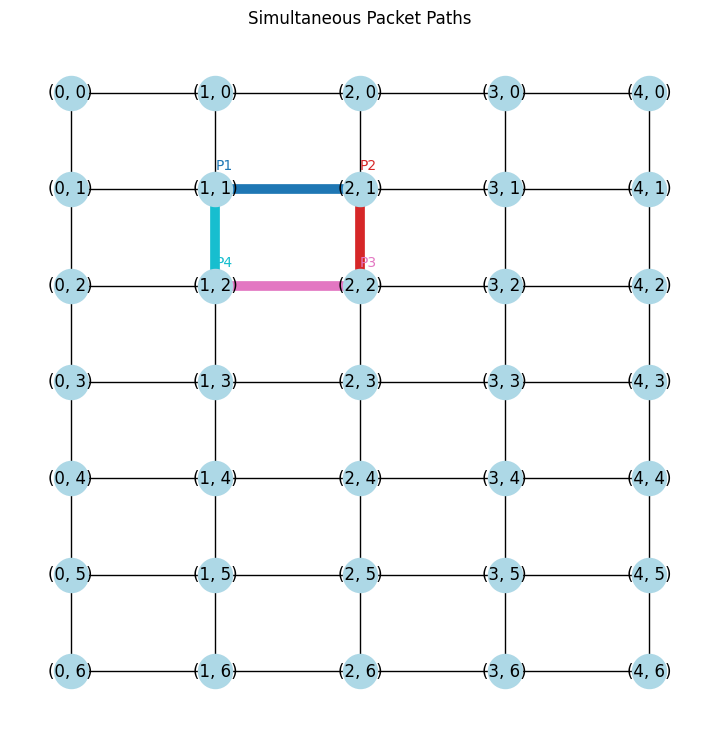

In [58]:
#XY Routing
packet_paths = [p[2] for p in deadlock_paths]  
draw_multiple_paths(G, positions, packet_paths)

## Valiant routing

Full Path: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (2, 4), (2, 3), (2, 2), (2, 1)] via Intermediate Node: (1, 5)
Full Path: [(2, 1), (1, 1), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (2, 5), (2, 4), (2, 3), (2, 2)] via Intermediate Node: (0, 5)
Full Path: [(2, 2), (2, 3), (1, 3), (1, 2)] via Intermediate Node: (2, 3)
Full Path: [(1, 2), (2, 2), (3, 2), (4, 2), (4, 3), (3, 3), (2, 3), (1, 3), (1, 2), (1, 1)] via Intermediate Node: (4, 3)


/tmp/ipykernel_67617/2495445561.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(packet_paths))  # tab10 = 10 distinct colors


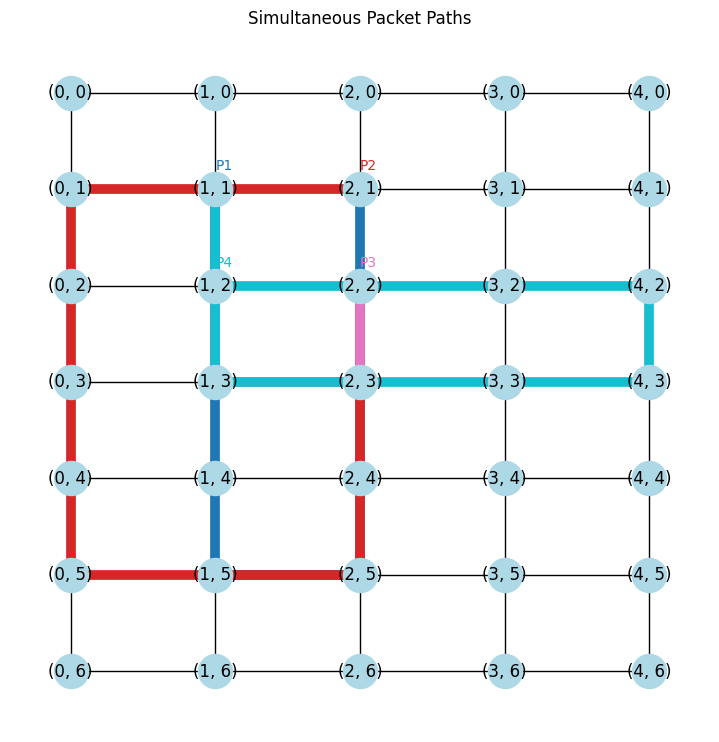

In [59]:
# Valiant routing
#collect all the sources and destinations to use 
sources = [p[0] for p in deadlock_paths]
destinations = [p[1] for p in deadlock_paths]
full_paths = []
intermediate_nodes = []
# Lets get the paths 
for source, destination in zip(sources, destinations):
    full_path, intermediate_node = valiant_routing(G, source, destination)
    full_paths.append(full_path)
    intermediate_nodes.append(intermediate_node)
    print(f"Full Path: {full_path} via Intermediate Node: {intermediate_node}")

draw_multiple_paths(G, positions, full_paths)


# Animation

## XY routing

/tmp/ipykernel_67617/549529994.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(packet_paths))  # tab10 = 10 distinct colors


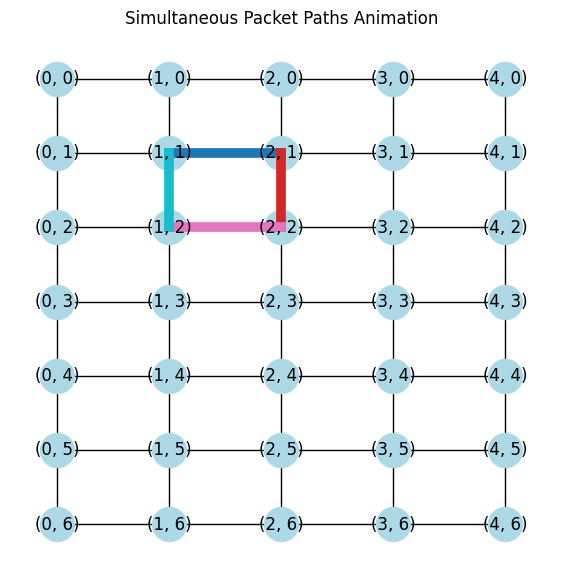

In [62]:
# Simulate deadlock with an animation
packet_paths = [p[2] for p in deadlock_paths]  
animate_packet_paths(G, positions, packet_paths, interval=500)

## Valiant routing

Full Path: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (2, 4), (2, 3), (2, 2), (2, 1)] via Intermediate Node: (1, 5)
Full Path: [(2, 1), (1, 1), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (2, 5), (2, 4), (2, 3), (2, 2)] via Intermediate Node: (0, 5)
Full Path: [(2, 2), (2, 3), (1, 3), (1, 2)] via Intermediate Node: (2, 3)
Full Path: [(1, 2), (2, 2), (3, 2), (4, 2), (4, 3), (3, 3), (2, 3), (1, 3), (1, 2), (1, 1)] via Intermediate Node: (4, 3)


/tmp/ipykernel_67617/549529994.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(packet_paths))  # tab10 = 10 distinct colors


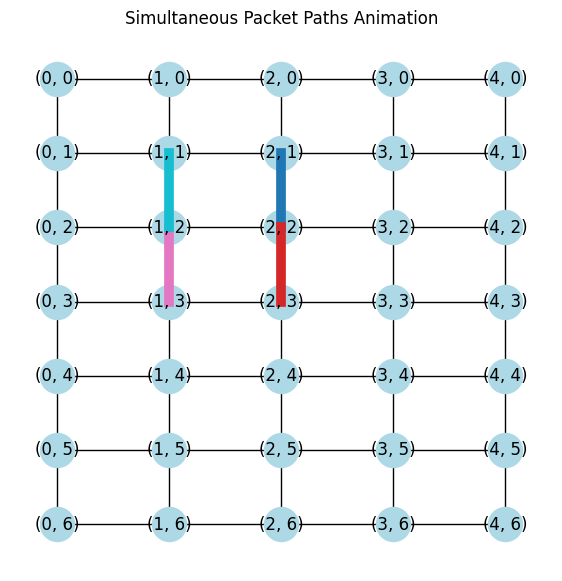

In [63]:
# print out packet info 
for i in range(len(full_paths)):
    print(f"Full Path: {full_paths[i]} via Intermediate Node: {intermediate_nodes[i]}")

animate_packet_paths(G, positions, full_paths, interval=500)